In [1]:
using DifferentialEquations,Plots,StatsBase

Please conduct a simulation of an epidemic using the SIR model (Kermack-McKendrick equations (1927)) described by the system of differential equations:

$$\frac{dS}{dt}=−\beta SI$$
$$\frac{dI}{dt}=\beta SI−\gamma I$$
$$\frac{dR}{dt}=\gamma I$$
where $\beta >0$ denotes the coefficient (rate) of infection spread, $\gamma >0$ is the recovery rate of infected individuals.

Initial conditions:

S- susceptible individuals $S(0)> 0$

I- infected individuals spreading the infection $I(0)>0$

R- recovered individuals $R(0)=0$.

Extension: Implement the epidemic model as a cellular automaton.
 * https://en.wikipedia.org/wiki/Epidemic_models_on_lattices
 * https://mathworld.wolfram.com/CellularAutomaton.html
 * https://grimmel.github.io/posts/2020/10/blog-post-1/

We use the Euler's method by rewriting the system of equations into a recursive form.
* https://en.wikipedia.org/wiki/Euler_method

$$S_{n+1} = S_n - dt \beta S_n I_n$$
$$I_{n+1} = I_n + dt(\beta S_n I_n - \gamma I_n)$$
$$R_{n+1} = R_n + dt\gamma I_n$$

### Euler method

In [2]:
S = 1
I = 1e-3
R = 0
dt = 1
beta = 0.5
gamma = 0.1;

In [3]:
function euler_method(S,I,R,dt,beta,gamma)
    Sn, In, Rn = BigFloat[S], BigFloat[I], BigFloat[R]

    num_iterations = ceil(Int, 100/dt)

    for i in 1:num_iterations
        prev_S, prev_I, prev_R = last(Sn), last(In), last(Rn)
        
        new_S = prev_S - beta * dt * prev_S * prev_I
        new_I = prev_I + dt * (beta * prev_S * prev_I - gamma * prev_I)
        new_R = prev_R + dt * gamma * prev_I
        
        push!(Sn, new_S)
        push!(In, new_I)
        push!(Rn, new_R)
    end
    return Sn,In,Rn
end        

euler_method (generic function with 1 method)

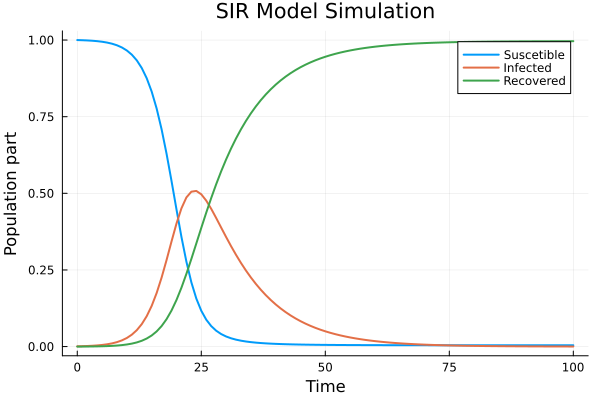

In [4]:
result = euler_method(S,I,R,dt,beta,gamma)

plot(
    0:dt:ceil(Int, 100/dt) * dt,
    [result[1] ,result[2] ,result[3]], 
    label=["Suscetible" "Infected" "Recovered"],
    xlabel="Time",
    ylabel="Population part",
    legend=:topright, 
    linewidth=2,   
    title="SIR Model Simulation"
)

### Runge-Kutta method

In [5]:
function runge_kutta(du,u,p,t)
    S,I,R = u
    β,γ = p 
    du[1] = - β*S*I #dS
    du[2] = β*S*I - γ*I #dI
    du[3] = γ*I #dR
end
u0 = [S,I,R]
tspan = (0,100)
p = [beta, gamma]
ode_problem = ODEProblem(runge_kutta,u0,tspan,p);

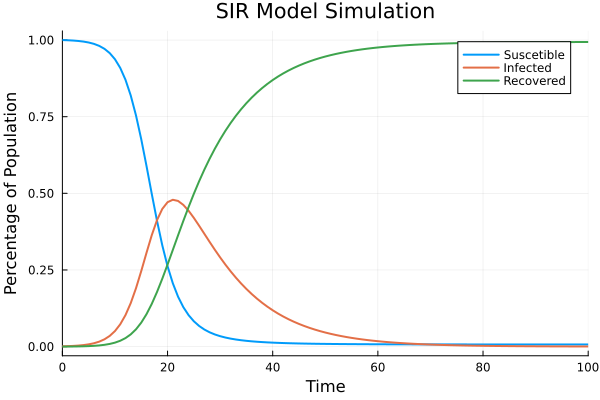

In [6]:
result = solve(ode_problem,saveat=1)   

plot(
    result,
    label=["Suscetible" "Infected" "Recovered"],
    xlabel="Time",
    ylabel="Percentage of Population",
    legend=:topright, 
    linewidth=2,   
    title="SIR Model Simulation"
)

In [7]:
euler, kutta = [], []

for i in 1:20
    tspan = (0,ceil(Int, 100/i) * i)
    ode_problem = ODEProblem(runge_kutta,u0,tspan,p)
    result1 = solve(ode_problem,saveat=1)
    result2 = euler_method(S,I,R,i,beta,gamma)
    push!(kutta,result1[ceil(Int, 100/i) ][1])
    push!(euler,result2[1][ceil(Int, 100/i) ])
end

plot(1:10, 
    [euler,kutta], 
    label=["Metoda Eulera" "Metoda Rungego-Kunty"],
    title="Liczba zarażonych (100. dzień) w zależności od kroku")

### Numerical stability

Euler's method, while simple, can suffer from numerical instability, especially with large time steps, due to its reliance on linear approximations and the potential for error propagation over time. This instability arises from the method's assumption of constant slope over small intervals, leading to significant errors in highly nonlinear or rapidly changing systems. In contrast, Runge-Kutta methods offer improved stability and accuracy by employing multiple stages and higher-order terms in the approximation, mitigating the effects of numerical instability. By incorporating additional information about the slope of the function at intermediate points and using adaptive step size control, Runge-Kutta methods can provide more reliable approximations, making them suitable for a wider range of differential equations and numerical integration tasks. Thus, while Euler's method remains useful for introductory purposes, Runge-Kutta methods are generally preferred for more complex or sensitive systems.

### Celluar automaton

In [14]:
beta = 0.3
gamma = 0.5

nt = 400
nx = 200
ny = 200;

state = zeros(Int8,nx,ny,nt)
state[100, 100, 1] = 1;

In [15]:
for t in 1:nt-1
    for j in 2:ny-1
        for i in 2:nx-1
            state[i,j,t+1] = state[i,j,t]
            
            if state[i,j,t] == 0
                for ni in -1:1
                    for nj in -1:1
                        if state[i+ni,j+nj,t] == 1 && state[i,j,t+1] == 0
                            state[i,j,t+1] = sample([0,1],Weights([1-beta,beta])) 
                        end
                    end
                end
            end
            
            if state[i,j,t] == 1
                state[i,j,t+1] = sample([1,2],Weights([1-gamma,gamma]))
            end
        end
    end
end

[ Info: Saved animation to C:\Users\macie\OneDrive\Pulpit\Studia\YEAR 2\mownit\Computation_Methods_for_Science_and_Technology\lab10\tmp.gif


Plots.AnimatedGif("C:\\Users\\macie\\OneDrive\\Pulpit\\Studia\\YEAR 2\\mownit\\Computation_Methods_for_Science_and_Technology\\lab10\\tmp.gif")
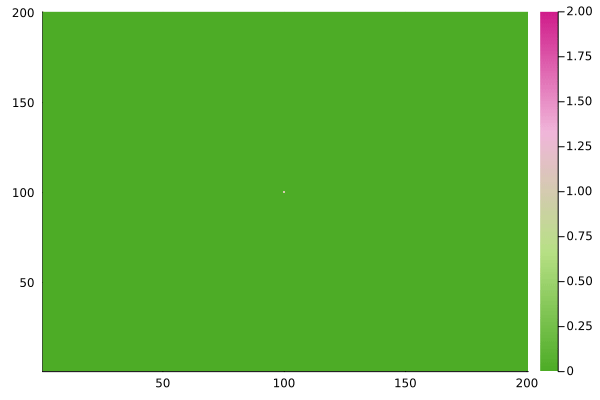

In [16]:
@gif for time ∈ 1:nt
    heatmap(state[:,:,time], clims=(0, 2), color=cgrad(:PiYG_4, rev=true))
end

*https://blog.devgenius.io/a-simple-cellular-automaton-of-plant-epidemics-in-julia-29ac62d87516